<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/LOGO_INP_N7.png" alt="N7" height="80"/>

<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/logo-insa.png" alt="INSA" height="80"/>

# Intégration numérique

- Date : 2023-2024
- Durée approximative : 1h15

## Introduction

Pour la documentation du package `Julia` sur l'intégration numérique,  voir
[documentation de DifferentialEquations.jl](https://diffeq.sciml.ai/stable/).

Il nous faut tout d'abord importer les bons packages de Julia.

In [1]:
# activate local project
using Pkg
Pkg.activate(".")

# load packages
using DifferentialEquations
using ForwardDiff
using LinearAlgebra
using Plots

  Activating project at `~/jbcaillau.github.io/tmp`


## Exemple 1

Nous allons ici résoudre le problème à valeur initiale
$$(IVP)\left\{\begin{array}{l}
\dot{x}_1(t)=x_1(t)+x_2(t)+\sin t\\
\dot{x}_2(t)=-x_1(t)+3x_2(t)\\
x_1(0)=-9/25\\
x_2(0)=-4/25,
\end{array}\right.
$$

- Ecrire la fonction $f$ qui permet d'écrire l'équation différentielle sous la forme $\dot{x}(t)=f(t,x(t))$.
- Vérifier que la solution de $(IVP)$ est
$$\begin{align*}
x_1(t)&= (-1/25)(13\sin t+9\cos t)\\
x_2(t)&= (-1/25)(3\sin t+4\cos t).
\end{align*}$$
- Coder la fonction $f$ et exécuter le code ci-dessous. Commentaires ?

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/90rnQ/src/performance_warnings.jl:32


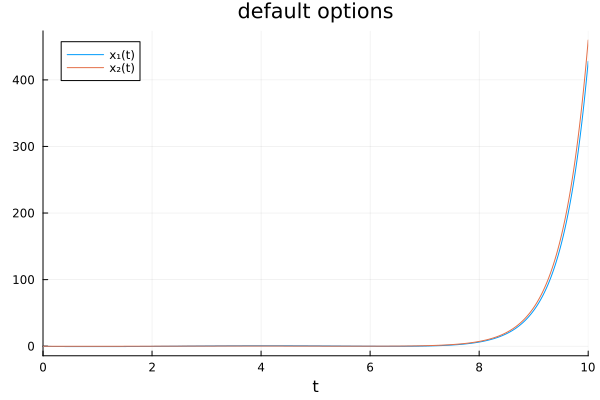

In [2]:
# Remarque : 
# un problème IVP est une équation différentielle ordinaire 
# (EDO en français, ODE en anglais)
# avec en plus une condition initiale.

"""
    Second membre de l'IVP
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps
"""
function exemple1(x, λ, t)
    xpoint = similar(x)
    xpoint[1] = x[1] + x[2] + sin(t)
    xpoint[2] = -x[1] + 3*x[2]
    return xpoint
end

λ  = [] # pas de paramètres

t0 = 0
tf = 10
tspan = (t0, tf) # intervalle d'intégration

x0   = [-9/25, -4/25] # condition initiale

prob = ODEProblem(exemple1, x0, tspan, λ)  # définition du problème IVP
sol  = solve(prob) # résolution du problème IVP
p1   = plot(sol, label = ["x₁(t)" "x₂(t)"], title = "default options") # affichage de la solution

## Le contrôle du pas
Les bons intégrateurs numériques ont une mise à jour automatique du pas. Pour les 
[méthodes de Runge-Kutta](https://fr.wikipedia.org/wiki/Méthodes_de_Runge-Kutta) 
par exemple, sur un pas $[t_0, t_{1}]$ on calcule par 2 schémas différents deux solutions approchées à l'instant $t_{1}$ : $x_{1}$ et $\hat{x}_{1}$ dont l'erreur locale est respectivement en $O(h^p)$ et $O(h^{p+1})$ (les erreurs globales sont elles en $O(h^{p-1})$ et $O(h^p)$). Ainsi on peut estimer l'erreur locale du schéma le moins précis à l'aide de la différence $x_{1}-\hat{x}_{1}$. On peut alors estimer le pas de façon à avoir la norme de cette différence inférieure à une tolérance donnée `Tol` ou encore à avoir 
$$\frac{\|x_{1}-\hat{x}_{1}\|}{\mathrm{Tol}}<1.$$

En pratique on considère des tolérences absolue et relative composante par composante et on définit : $\mathrm{sc}_i = \mathrm{abstol}_i + \mathrm{reltol}_i \times \max(|x_{0i}|,|x_{1i}|)$. On calcule alors le pas de façon à avoir 

$$\mathrm{err} = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\frac{x_{1i}-\hat{x}_{1i}}{\mathrm{sc}_i}\right)^2}<1.$$


Référence : [Hairer, Nørsett, Wanner (2008) Solving Ordinary Differential Equations I Nonstiff Problems](https://link.springer.com/book/10.1007/978-3-540-78862-1).

Dans `Julia`, on peut modifier les valeurs par défaut  : reltol = 1.e-3 et abstol = 1.e-6
(lorsque ces valeurs sont des scalaires, on considère les mêmes quantités pour toutes les composantes).

Réaliser l'intégration numérique pour 
- reltol = 1e-3 et abstol = 1e-6
- reltol = 1e-6 et abstol = 1e-9
- reltol = 1e-10 et abstol = 1e-15

et afficher les résultats en ajoutant la solution.

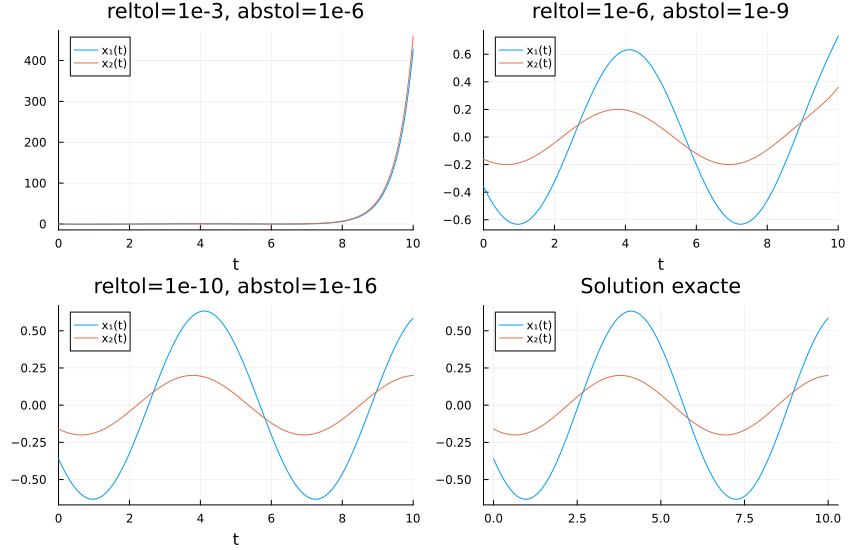

In [3]:
# calcul avec les options par défaut
sol = solve(prob, reltol = 1e-3, abstol = 1e-6)
p1 = plot(sol, label = ["x₁(t)" "x₂(t)"], title = "reltol=1e-3, abstol=1e-6")

#
sol = solve(prob, reltol = 1e-6, abstol = 1e-9)
p2 = plot(sol, label = ["x₁(t)" "x₂(t)"], title = "reltol=1e-6, abstol=1e-9")

#
sol = solve(prob, reltol = 1e-10, abstol = 1e-15)
p3 = plot(sol, label = ["x₁(t)" "x₂(t)"], title = "reltol=1e-10, abstol=1e-16")

# solution exacte
T = t0:(tf-t0)/100:tf
sinT = sin.(T) # opération vectorielle
cosT = cos.(T)
p4 = plot(T,[(-1/25)*(13*sinT+9*cosT) (-1/25)*(3*sinT+4*cosT)], label = ["x₁(t)" "x₂(t)"], title = "Solution exacte")

# affichage
plot(p1, p2, p3, p4, size=(850, 550))

## Sur l'explosion des solutions en temps fini

Nous allons ici résoudre le problème à valeur initiale $\dot{x}(t) = 1 + x^p(t)$ avec $p \ge 1$ et $x(0)=0$. 

- Coder la fonction $f$ qui permet d'écrire l'équation différentielle sous la forme $\dot{x}(t)=f(t,x(t))$.
- Déterminer à partir de quelle valeur de $p\ge 1$ la solution explose en temps fini (à $0.1$ près) inférieur à la valeur 3.

┌ Warning: dt(4.440892098500626e-16) <= dtmin(4.440892098500626e-16) at t=2.870177017353864, and step error estimate = 0.7109137378877439. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/90rnQ/src/integrator_interface.jl:599
┌ Warning: dt(4.440892098500626e-16) <= dtmin(4.440892098500626e-16) at t=1.5707963286887061, and step error estimate = 0.46564768242846055. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/90rnQ/src/integrator_interface.jl:599


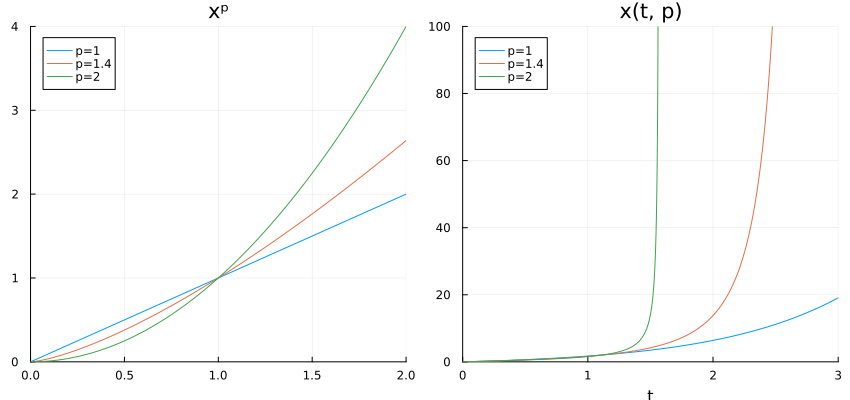

In [4]:
"""
    Second membre de l'IVP
    x : vecteur d'état
    p : scalaire
    t : variable de temps. Ici le temps n'intervient pas explicitement, le système est autonome.
"""
function f(x, p, t)
    return 1+x^p
end

#
x0 = 0.0
t0 = 0.0
tf = 3
tspan = (t0, tf) # instants initial et terminal

#
xspan = 0:0.01:2

#
pf = plot(title="xᵖ")
px = plot(title="x(t, p)")

#
p = 1
prob = ODEProblem(f, x0, tspan, p, reltol = 1.e-8, abstol = 1.e-8) # définition du problème en Julia
sol = solve(prob) # intégration numérique
pf = plot!(pf, xspan, x -> (f(x, p, t0)-1), label = "p=$p") # affichage du second membre
px = plot!(px, sol, label = "p=$p") # affichage de la solution

#
p = 1.4
prob = ODEProblem(f, x0, tspan, p, reltol = 1.e-8, abstol = 1.e-8) # définition du problème en Julia
sol = solve(prob) # intégration numérique
pf = plot!(pf, xspan, x -> (f(x, p, t0)-1), label = "p=$p") # affichage du second membre
px = plot!(px, sol, label = "p=$p") # affichage de la solution

#
p = 2
prob = ODEProblem(f, x0, tspan, p, reltol = 1.e-8, abstol = 1.e-8) # définition du problème en Julia
sol = solve(prob) # intégration numérique
pf = plot!(pf, xspan, x -> (f(x, p, t0)-1), label = "p=$p") # affichage du second membre
px = plot!(px, sol, label = "p=$p") # affichage de la solution

#
plot!(pf, xlims=(0, 2), ylims=(0, 4))
plot!(px, xlims=(t0, tf), ylims=( 0, 100))
plot(pf, px, size=(850, 400))

## Pendule simple

On s'intéresse ici au [pendule simple](https://fr.wikipedia.org/wiki/Pendule_simple). Les principes physiques de la mécanique classique donnent comme équation qui régit l'évolution du mouvement

$$ ml^2\ddot{\alpha}(t)+mlg\sin(\alpha(t)) +k\dot{\alpha}(t)=0,$$
où $\ddot{\alpha}(t)$ désigne la dérivée seconde de l'angle $\alpha$ par rapport au temps $t$. 

- En prenant comme variable d'état $x=(x_1,x_2)=(\alpha, \dot{\alpha})$, écrire la fonction $f$ qui permet d'écrire l'équation différentielle sous la forme $\dot{x}(t) = f(t,x(t))$.
- Coder cette fonction ci-dessous et exécuter le code. D'après-vous, observez-vous une oscillation ou une rotation du pendule ? 
- Remplacer la vitesse angulaire initiale $\dot{\alpha}(0)$ par $2$. Commentaires.

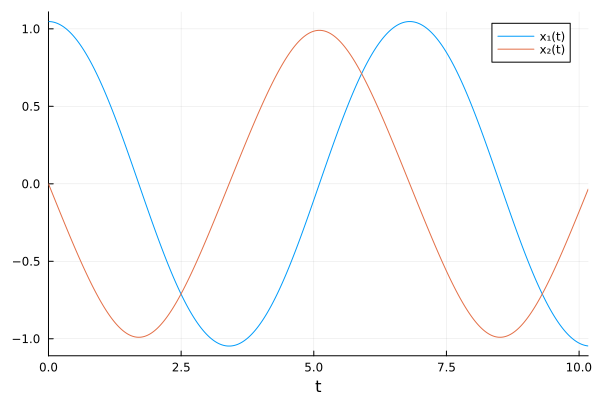

In [5]:
"""
    Second membre de l'IVP
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps. Ici le temps n'intervient pas explicitement, le système est autonome.
"""
function pendule(x, λ, t)
    xpoint = similar(x)
    g, l, k, m = λ
    xpoint[1] = x[2]
    xpoint[2] = -(g/l)*sin(x[1]) - k*x[2]/(m*l^2)
    return xpoint  
end

#
g = 9.81
l = 10
k = 0
m = 1
λ = [g, l, k, m] # paramètres constants

theta0 = pi/3
x0 = [theta0, 0] # état initial

t0 = 0
tf = 3*pi*sqrt(l/g)*(1 + theta0^2/16 + theta0^4/3072) # 2*approximation de la période
tspan = (t0, tf) # instants initial et terminal

prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8) # définition du problème en Julia
sol = solve(prob) # intégration numérique

plot(sol, label = ["x₁(t)" "x₂(t)"]) # affichage de la solution

**Diagramme de phases.**

- Exécutez le code ci-dessous et interprétez le graphique: où sont les oscillations, les rotations et les points d'équilibre stables et instables ?
- On considère le cas où $k=0.15$ (on introduit un frottement). Que se passe-t-il ?

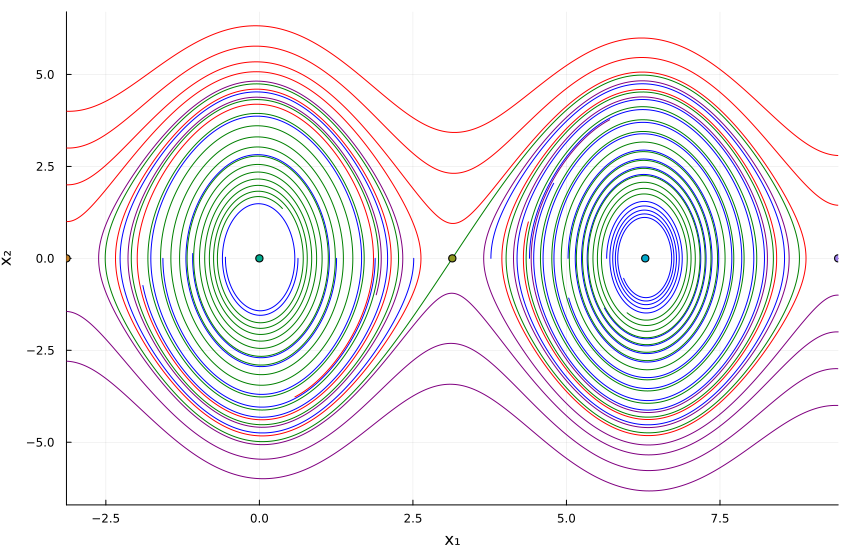

In [6]:
#
g = 9.81
l = 1.5
k = 0.15
m = 1
λ = [g, l, k, m] # paramètres constants

plt = plot(xlabel = "x₁", ylabel = "x₂", legend = false) # initialisation du plot

for theta0 in 0:(2*pi)/10:2*pi
    theta0_princ = theta0
    tf = 3*pi*sqrt(l/g)*(1 + theta0_princ^2/16 + theta0_princ^4/3072) # 2*approximation of the period
    tspan = (0.0,tf)
    x0 = [theta0 0]
    prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(plt, sol, idxs=(1,2), color="blue")  # lw = linewidth
end

theta0 = pi-10*eps()
x0 = [theta0 0]
tf = 50                              # problem for tf=50 1/4 of the period!
tspan = (0.0,tf)
prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
sol = solve(prob)
plot!(plt, sol, idxs=(1,2), xlims = (-2*pi,4*pi), color="green")  # lw = linewidth

theta0 = pi+10*eps()
x0 = [theta0 0]
tf = 50
tspan = (0.0,tf)
prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
sol = solve(prob)
plot!(plt, sol, idxs=(1,2), xlims = (-2*pi,4*pi), color="green")  # lw = linewidth

# circulation case
for thetapoint0 in 0:1.:4         
    tf = 10
    tspan = (0.,tf)
    x0 = [-pi thetapoint0]                # thetapoint0 > 0 so theta increases from -pi to ...
    prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(plt, sol, idxs=(1,2), color="red")  # lw = linewidth
end
for thetapoint0 in -4:1.:0
    tf = 10
    tspan = (0.,tf)
    x0 = [3*pi thetapoint0]              # thetapoint0 < 0 so theta decreases from 3pi to ...
    prob = ODEProblem(pendule, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(plt, sol, idxs=(1,2), color="purple")  # lw = linewidth
end
plot!(plt, [-pi 0 pi 2*pi 3*pi], [0 0 0 0 0], seriestype=:scatter)
plot!(plt, xlims = (-pi,3*pi), size=(850, 550))


In [7]:
# Jacobienne de la fonction vdp 
dfdx(x) = ForwardDiff.jacobian(x -> pendule(x, λ, 0), x)

# Point d'équilibre et la matrice Jacobienne en ce point
xe = [0., 0.]
A = dfdx(xe)

# Valeurs propres de la matrice Jacobienne
eigvals(A)

2-element Vector{ComplexF64}:
 -0.03333333333333334 - 2.5571251218680886im
 -0.03333333333333334 + 2.5571251218680886im

In [8]:
# Point d'équilibre et la matrice Jacobienne en ce point
xe = [π, 0.]
A = dfdx(xe)

# Valeurs propres de la matrice Jacobienne
eigvals(A)

2-element Vector{Float64}:
 -2.5908929340291045
  2.524226267362437

## Modèle de Van der Pol

L'équation différentielle considérée est l'[équation de Van der Pol](https://fr.wikipedia.org/wiki/Oscillateur_de_Van_der_Pol)
$$(IVP)\left\{\begin{array}{l}
\dot{x}_1(t)=x_2(t)\\
\dot{x}_2(t)=(1-x_1^2(t))x_2(t)-x_1(t)\\
x_1(0)=2.00861986087484313650940188\\
x_2(0)=0
\end{array}\right.
$$
jusqu'au temps $t_f=T=6.6632868593231301896996820305$, où $T$ est la période de la solution.

Codez le second membre de l'IVP ci-dessous et exécutez le code. Commentaires.

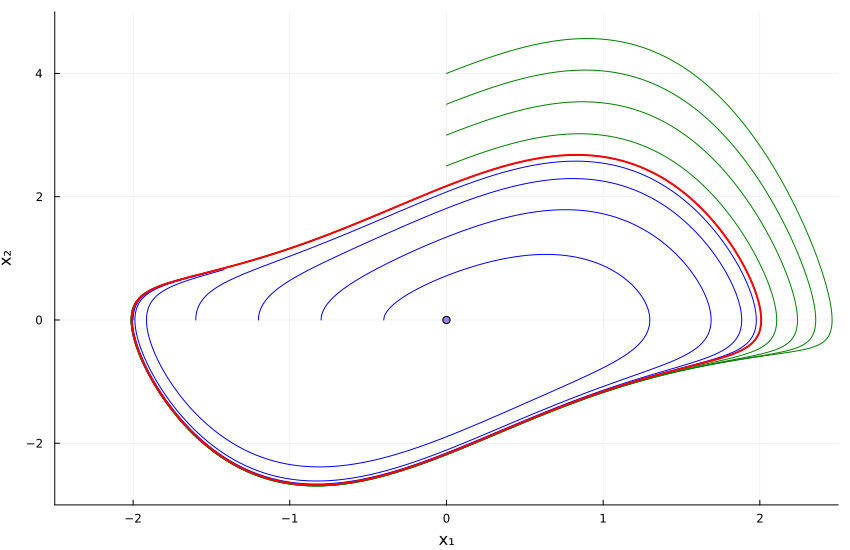

In [9]:
"""
    Second membre de l'IVP: modèle de Van der Pol
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps. Ici le temps n'intervient pas explicitement, le système est autonome.
"""
function vdp(x, λ, t)
    xpoint = similar(x)
    xpoint[:] = [x[2] , (1-x[1]^2)*x[2] - x[1]]
    return xpoint
end

#
t0 = 0
tf = 6.6632868593231301896996820305
tspan = (t0, tf)

#
plot(xlabel = "x₁", ylabel = "x₂", legend = false)

# Trajectoires intérieures
for x01 in -2:0.4:0
    x0 = [x01,0]
    prob = ODEProblem(vdp, x0, tspan, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(sol, idxs=(1,2), color = "blue") 
end

# Trajectoires extérieures
for x02 in 2.5:0.5:4
    x0 = [0,x02]
    prob = ODEProblem(vdp, x0, tspan, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(sol, idxs=(1,2), color = "green")
end

# Cycle limite périodique
x0 = [2.00861986087484313650940188,0]
prob = ODEProblem(vdp, x0, tspan, reltol = 1.e-8, abstol = 1.e-8)
sol  = solve(prob)
plot!(sol, idxs=(1,2), color = "red", lw = 2.)

#
plot!([0], [0], seriestype=:scatter)        # point d'équilibre
plot!(xlims = (-2.5, 2.5), ylims = (-3, 5), size=(850, 550))

**Stabilité.**

On calcule ci-dessous les valeurs propres de la matrice jacobienne du second membre de l'IVP au point d'équilibre $x_e = (0, 0)$. Commentaires (pour les étuidants N7 rappelez-vous votre cours d'[automatique](https://gitlab.irit.fr/toc/etu-n7/controle-optimal/-/raw/master/ressources/notes-autom-2021.pdf)).

In [10]:
# Jacobienne de la fonction vdp 
dvdp(x) = ForwardDiff.jacobian(x -> vdp(x, [], 0), x)

# Point d'équilibre et la matrice Jacobienne en ce point
xe = [0, 0]
A = dvdp(xe)

# Valeurs propres de la matrice Jacobienne
eigvals(A)

2-element Vector{ComplexF64}:
 0.5 - 0.8660254037844385im
 0.5 + 0.8660254037844385im

## Modèle proie-prédateur (modèle de Lotka-Volterra)

L'équation différentielle considérée est donnée par les [équations de prédation de Lotka-Volterra](https://fr.wikipedia.org/wiki/Équations_de_prédation_de_Lotka-Volterra)

$$\left\{\begin{array}{l}
\dot{x}_1(t)= \phantom{-}x_1(t) ( \alpha - \beta x_2(t))  \\[0.5em]
\dot{x}_2(t)= -x_2(t) ( \gamma - \delta x_1(t))
\end{array}\right.
$$

où

- $t$ est le temps ;
- $x(t)$ est l'effectif des proies en fonction du temps ;
- $y(t)$ est l'effectif des prédateurs en fonction du temps ;

Les paramètres suivants caractérisent les interactions entre les deux espèces :

- $\alpha$, taux de reproduction intrinsèque des proies (constant, indépendant du nombre de prédateurs) ;
- $\beta$, taux de mortalité des proies dû aux prédateurs rencontrés ;
- $\delta$, taux de reproduction des prédateurs en fonction des proies rencontrées et mangées ;
- $\gamma$, taux de mortalité intrinsèque des prédateurs (constant, indépendant du nombre de proies) ;

**Questions.**

- Le point $(0, 0)$ est clairement un point d'équilibre stable. Il existe un autre point d'équilibre, lequel ?
- Afficher l'autre point d'équilibre ainsi que quelques trajectoires du système dans le plan de phase, qui rentrent dans les limites du plot ci-dessous. Qu'observez-vous sur les trajectoires.

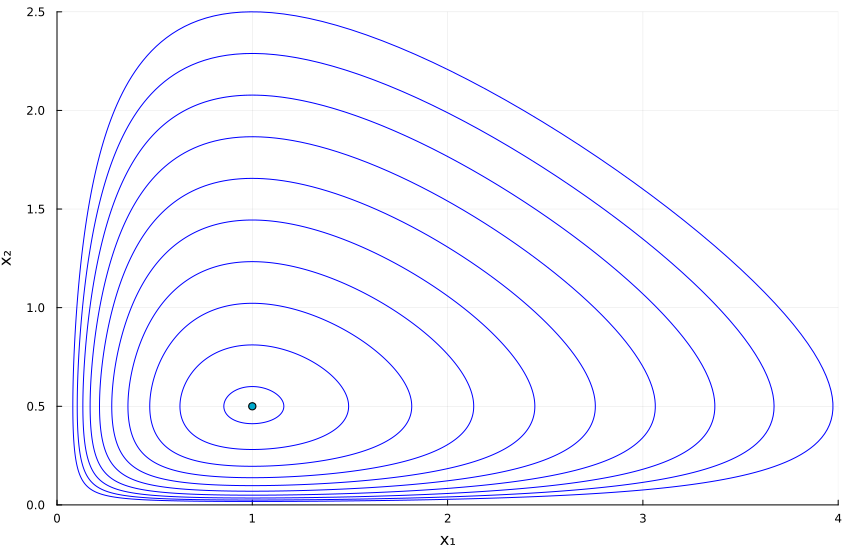

In [11]:
"""
    Second membre de l'IVP
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps. Ici le temps n'intervient pas explicitement, le système est autonome.
"""
function lv(x, λ, t)
    xpoint = similar(x)
    α, β, γ, δ = λ
    xpoint[:] = [α*x[1] - β*x[1]*x[2] , δ*x[1]*x[2] - γ*x[2]]
    return xpoint
end

α = 2/3
β = 4/3
γ = 1
δ = 1
λ = [α, β, γ, δ]

t0 = 0
tf = 20
tspan = (t0, tf)

plt = plot(xlabel = "x₁", ylabel = "x₂", legend = false)

for x02 ∈ range(0.6, 2.5, length = 10)
    x0 = [1, x02]
    prob = ODEProblem(lv, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
    sol = solve(prob)
    plot!(plt, sol, idxs=(1,2), color=:blue) 
end

#
plot!([γ/δ], [α/β], seriestype=:scatter)   # point d'équilibre
plot!(xlims = (0, 4), ylims = (0, 2.5), size=(850, 550))

In [12]:
# Jacobienne de la fonction vdp 
dfdx(x) = ForwardDiff.jacobian(x -> lv(x, λ, 0), x)

# Point d'équilibre et la matrice Jacobienne en ce point
xe = [γ/δ, α/β]
A = dfdx(xe)

# Valeurs propres de la matrice Jacobienne
eigvals(A)

2-element Vector{ComplexF64}:
 0.0 - 0.816496580927726im
 0.0 + 0.816496580927726im

## Phénomène de résonance

Soit $\omega$ et $\omega_0$ deux réels strictement positifs. On considère l'équation différentielle

$$\ddot{y}(t) + \omega_0^2 y(t) = \cos(\omega t).$$

- En prenant comme variable d'état $x=(x_1,x_2)=(y, \dot{y})$, écrire la fonction $f$ qui permet d'écrire l'équation différentielle sous la forme $\dot{x}(t) = f(t,x(t))$.
- Coder cette fonction ci-dessous et exécuter le code : les solutions sont-elles bornées ?
- Remplacer la vitesse angulaire pour avoir $\omega = \omega_0$. Commentaires.

[ Info: Saved animation to /home/caillau/jbcaillau.github.io/tmp/tmp.gif


Plots.AnimatedGif("/home/caillau/jbcaillau.github.io/tmp/tmp.gif")
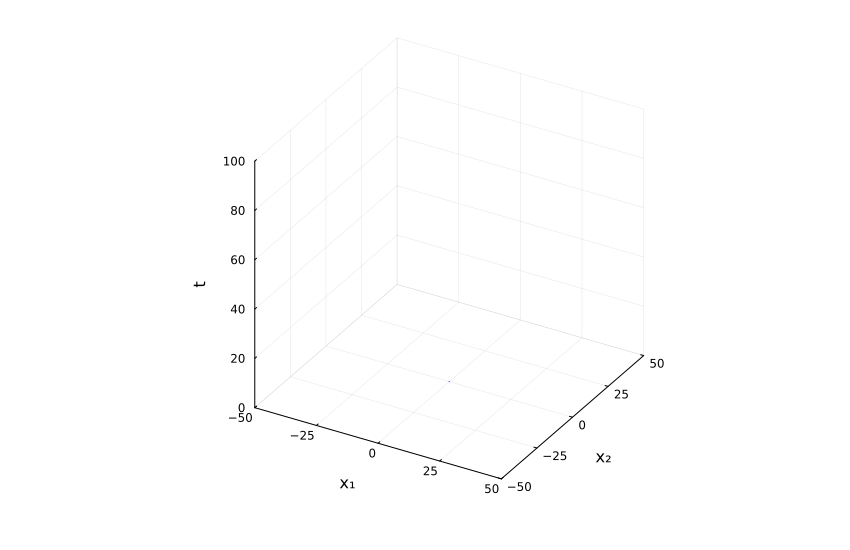

In [13]:
"""
    Second membre de l'IVP
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps. Ici le temps intervient explicitement, le système est non autonome.
"""
function resonance(x, λ, t)

    xpoint = similar(x)
    ω, ω₀ = λ
    
    #
    xpoint[:] = [x[2] , -ω₀^2*x[1] + cos(ω*t)]
    
    return xpoint
end

# parameters
ω  = 1
ω₀ = 1 #/2
λ  = [ω, ω₀]

# integration times
t0 = 0
tf = 100
tspan = (t0, tf)

# initial condition
x0 = [0, 0]

# define the problem and solve it
prob = ODEProblem(resonance, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
sol = solve(prob)

function makegif()

    #
    plt = plot(xlabel = "x₁", ylabel = "x₂", zlabel = "t", legend = false)

    #
    ω == ω₀ ? lim = 50 : lim = 5
    plot!(xlims = (-lim, lim), ylims = (-lim, lim), zlims = (t0, tf), size=(850, 550))

    # get x1, x2, t from sol
    x1 = [sol.u[i][1] for i ∈ 1:length(sol.u)]
    x2 = [sol.u[i][2] for i ∈ 1:length(sol.u)]
    t  = sol.t

    # plot the trajectory step by step and make a gif
    i = 1
    @gif for j ∈ 2:2:length(sol.t)
        # plot the trajectory part from i to j
        plot!(plt, x1[i:j], x2[i:j], t[i:j], color=:blue)
        # update i 
        i = j
    end

end

makegif()

## Attracteur de Lorenz

L'équation différentielle considérée est l'[équation de Lorenz](https://fr.wikipedia.org/wiki/Attracteur_de_Lorenz) donnée par

$$\left\{\begin{array}{l}
\dot{x}_1(t)= \phantom{-}\sigma (x_2(t) - x_1(t))  \\[0.5em]
\dot{x}_2(t)= \rho\, x_1(t) - x_2(t) - x_1(t)\, x_3(t)  \\[0.5em]
\dot{x}_3(t)= x_1(t)\, x_2(t) - \beta x_3(t)
\end{array}\right.
$$

où 

- $t$ est le temps ;
- $x(t)$ est proportionnel à l'intensité du mouvement de convection ;
- $y(t)$ est proportionnel à la différence de température entre les courants ascendants et descendants ;
- $z(t)$ est proportionnel à la déviation du profil vertical de température par rapport à la valeur linéaire de référence.
- $\sigma$, $\beta$ et $r$ sont des paramètres réels positifs.
- $\sigma$ est le nombre de Prandtl ;
- $\rho$ est le nombre de "Rayleigh".

On fixe souvent $\sigma = 10$, $\beta = 8/3$ et $\rho = 28$ pour illustrer le phénomène de chaos.

Compléter le code ci-dessous et exécuter le. Observer le phénomène de chaos. Vous pouvez modifer la condition initiale.

[ Info: Saved animation to /home/caillau/jbcaillau.github.io/tmp/lorentz.gif


Plots.AnimatedGif("/home/caillau/jbcaillau.github.io/tmp/lorentz.gif")
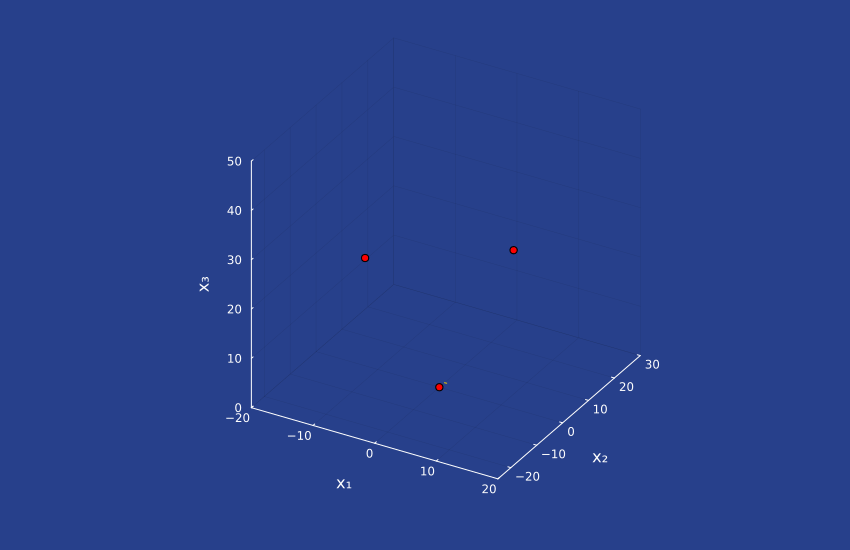

In [14]:
"""
    Second membre de l'IVP
    x : vecteur d'état
    λ : vecteur de paramètres
    t : variable de temps. Ici le temps intervient explicitement, le système est non autonome.
"""
function Lorentz(x, λ, t)

    xpoint = similar(x)
    σ, ρ, β = λ
    
    #
    xpoint[:] = [σ*(x[2] - x[1]) , x[1]*(ρ - x[3]) - x[2] , x[1]*x[2] - β*x[3]]
    
    return xpoint
end

# parameters
σ = 10
ρ = 28
β = 8/3
λ = [σ, ρ, β]

# integration times
t0 = 0
tf = 100
tspan = (t0, tf)

# initial condition
x0 = [0, 2, 0]

# define the problem and solve it
prob = ODEProblem(Lorentz, x0, tspan, λ, reltol = 1.e-8, abstol = 1.e-8)
sol = solve(prob)

function makegif()

    #
    plt = plot(xlabel = "x₁", ylabel = "x₂", zlabel = "x₃", legend = false)

    # 
    plot!(plt, background_color = :royalblue4)

    # update the color of axis of the figure to white
    plot!(plt, axiscolor = :white, tickfontcolor = :white, bordercolor = :white, fg_color_guide = :white)

    # plot the three equilibrium points
    plot!(plt, [0], [0], [0], seriestype=:scatter, color=:red)
    plot!(plt, [ sqrt(β*(ρ-1))], [ sqrt(β*(ρ-1))], [ρ-1], seriestype=:scatter, color=:red)
    plot!(plt, [-sqrt(β*(ρ-1))], [-sqrt(β*(ρ-1))], [ρ-1], seriestype=:scatter, color=:red)

    # get x1, x2, t from sol
    x1 = [sol.u[i][1] for i ∈ 1:length(sol.u)]
    x2 = [sol.u[i][2] for i ∈ 1:length(sol.u)]
    x3 = [sol.u[i][3] for i ∈ 1:length(sol.u)]

    # print min and max of each coordinate
    #println("x1 : ", minimum(x1), " ", maximum(x1))
    #println("x2 : ", minimum(x2), " ", maximum(x2))
    #println("x3 : ", minimum(x3), " ", maximum(x3))

    #
    plot!(xlims = (-20, 20), ylims = (-25, 30), zlims = (0, 50), size=(850, 550))

    # print length of the time grid
    #println("t : ", length(sol.t))

    # 
    duration = 10
    fps      = 10
    frames   = fps*duration
    step     = length(sol.t) ÷ frames

    # plot the trajectory step by step and make a gif
    i = 1
    animation = @animate for j ∈ 2:step:length(sol.t)
        # plot the trajectory part from i to j
        plot!(plt, x1[i:j], x2[i:j], x3[i:j], color=:gold2)
        # update i 
        i = j
    end

    gif(animation, "lorentz.gif", fps=fps)

end

makegif()